# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from pprint import pprint

%matplotlib inline

In [2]:
dataset = get_dataset("/home/workspace/data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_images(batch):

    img = batch['image'].numpy()
    boxes = batch['groundtruth_boxes'].numpy()
    classes = batch['groundtruth_classes'].numpy()
    colors = {1:'red', 2:'blue', 4:'green'}
    
    f, ax = plt.subplots(1)
    ax.imshow(img)
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    for bb,cl in zip(boxes, classes):
        y1, x1, y2, x2 = bb
        y1 = y1*img_height
        x1 = x1*img_width
        y2 = y2*img_height
        x2 = x2*img_width

        rec = patches.Rectangle((x1,y1), x2-x1,y2-y1, facecolor = 'none', edgecolor=colors[cl],linewidth=2)
        ax.add_patch(rec)
        
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

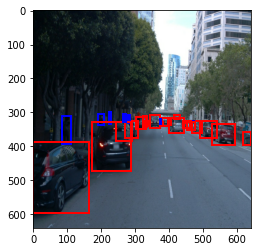

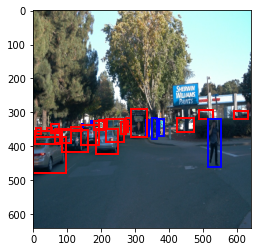

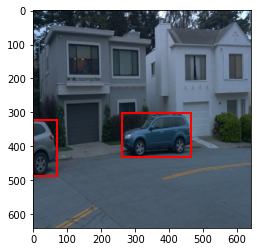

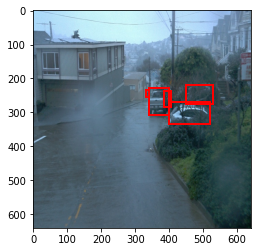

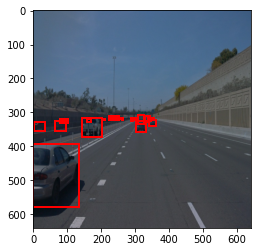

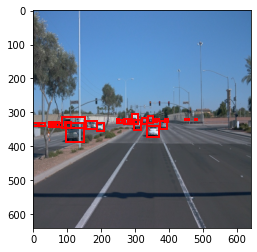

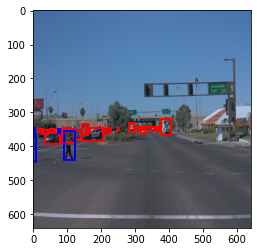

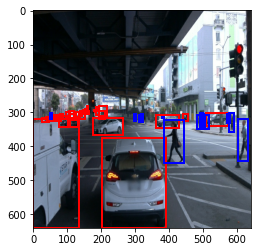

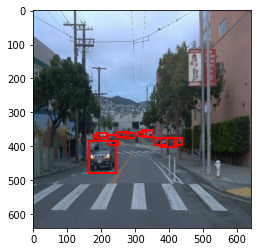

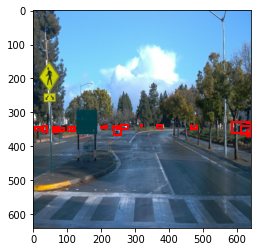

In [4]:
# Display 10 random images in dataset
random_set = dataset.shuffle(buffer_size=10).take(10)
for batch in random_set:
    display_images(batch)


## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

Some additional analyses we could include:

0. Size of dataset
1. The distribution of classes in the dataset to determine if it is balanced.
2. Tthe distribution of classes by object area.
3. The distribution of classes by object position.
4. The distribution of aspects like brightness and other lighting conditions in the images.
5. How many difficult cases we faced in the data.
6. The frequency of different kinds of classes in images.

Below, number 1, 2, 3, and 6 are shown.

We know there are three classes. For each of them, we want to record how many occur in a give sample, their size, and their position.

In [5]:
# Create dictionaries to store all the information
# We are using globals here to store the data
import pprint

object_counts = {1: 0, 2: 0, 4: 0}
object_areas = {1: [], 2: [], 4: []}
object_center_locs = {1: [], 2: [], 4: []}
objects_per_image = {1: [], 2: [], 4: []}

# Parse the image for the information we desire
def parse_image(img, boxes, classes):
    img_height = img.shape[0]
    img_width = img.shape[1]
    objects_in_image = {1: 0, 2: 0, 4: 0}
    
    for bb,cl in zip(boxes, classes):
        # record occurence of class
        object_counts[cl] += 1
        objects_in_image[cl] += 1
        
        # get location information
        y1, x1, y2, x2 = bb
        y1 = y1*img_height
        x1 = x1*img_width
        y2 = y2*img_height
        x2 = x2*img_width
        x_center = x1 + (x2-x1)/2
        y_center = y1 + (y2-y1)/2
        
        object_center_locs[cl].append((x_center, y_center))
        
        # get area information
        area = (x2-x1)*(y2-y1)
        object_areas[cl].append(area)
    
    for key,values in objects_per_image.items():
        objects_per_image[key].append(objects_in_image[key])
    
    
# If performance was more in control, I would shuffle these
random_set = dataset.take(40000)
for image in random_set:
    img = image['image'].numpy()
    boxes = image['groundtruth_boxes'].numpy()
    classes = image['groundtruth_classes'].numpy()
#     display_images(image)
    parse_image(img, boxes, classes)

    


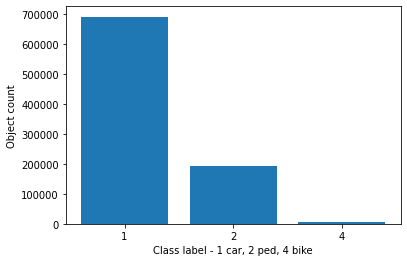

In [6]:
# Bar Chart for class count
fig = plt.figure()
plt.xlabel('Class label - 1 car, 2 ped, 4 bike')
plt.ylabel('Object count')
labels = [str(s) for s in object_counts.keys()]
plt.bar(labels,object_counts.values())
plt.show()


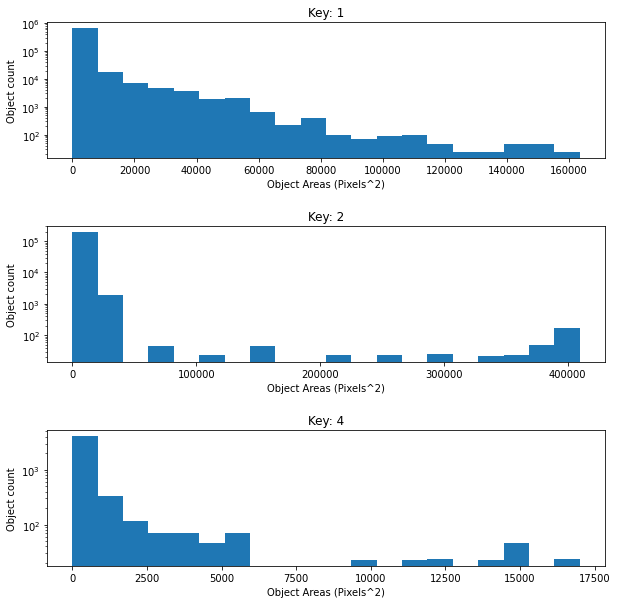

In [23]:
# Histogram for areas of the ground truth classes
fig, ax = plt.subplots(nrows=len(object_areas),ncols=1, figsize=(10,10))
max_area = {1:0, 2:0, 3:0}
for key in object_areas:
    max_area[key] = max(object_areas[key])

for idx, key in enumerate(object_areas):
    ax[idx].hist(object_areas[key], bins=20, log=True)
    ax[idx].set_title(f'Key: {key}')
    ax[idx].set_xlabel(f'Object Areas (Pixels^2)')
    ax[idx].set_ylabel(f'Object count')
    

plt.subplots_adjust(hspace = .5)
plt.show()


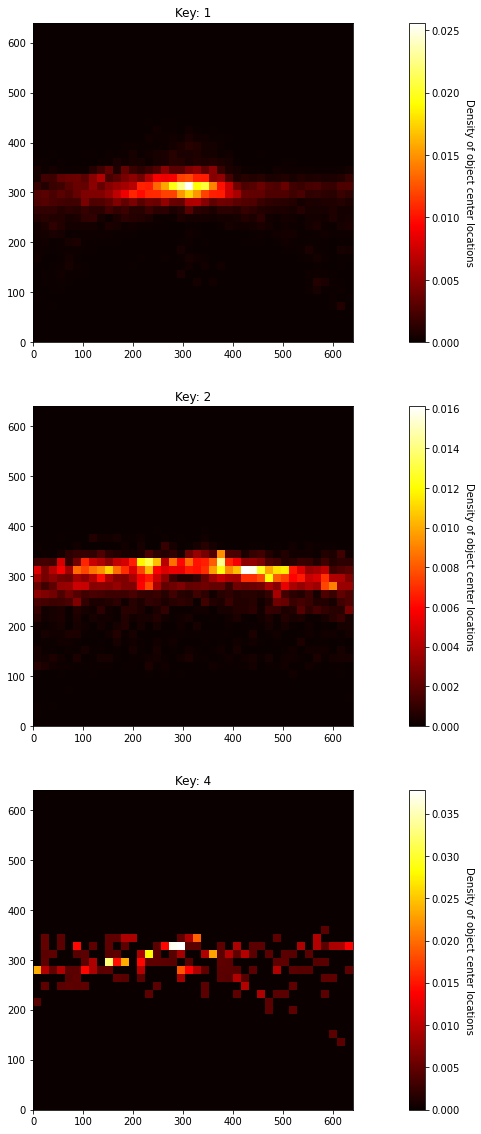

In [22]:
# Heatplot showing the distribution of objects center locations
fig, ax = plt.subplots(nrows=len(objects_per_image),ncols=1, figsize=(20,20))

for idx, (key, center_locs) in enumerate(object_center_locs.items()):
    counts, xbins, ybins = np.histogram2d([loc[1] for loc in center_locs], 
                                          [loc[0] for loc in center_locs], 
                                          bins=40, range = [[0,640],[0,640]])
    counts = counts/counts.sum()
    
    ax[idx].imshow(counts, cmap='hot', interpolation='nearest',extent = [0,640,0,640])
    ax[idx].set_title(f'Key: {key}')
    
    cbar = ax[idx].figure.colorbar(ax[idx].images[0],ax=ax[idx])
    cbar.ax.set_ylabel('Density of object center locations', rotation =-90, va='bottom')

plt.show()


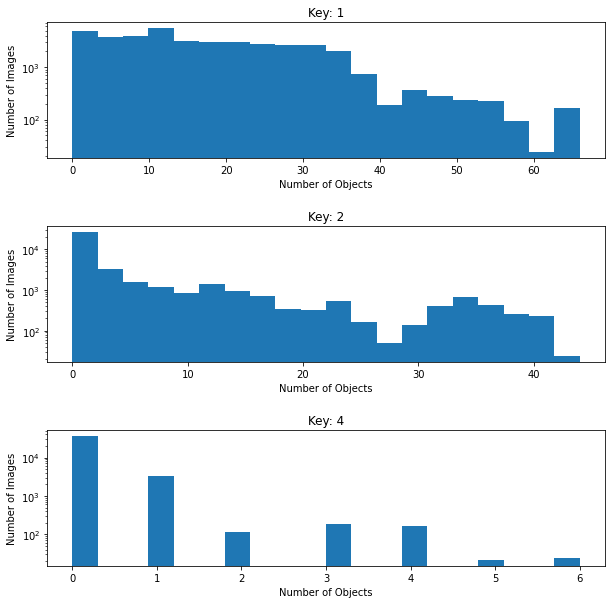

In [18]:
# Histogram of the frequency of a number of objects per image
fig, ax = plt.subplots(nrows=len(objects_per_image),ncols=1, figsize=(10,10))
for idx, key in enumerate(objects_per_image):
    ax[idx].hist(objects_per_image[key], bins=20, log=True)
    ax[idx].set_title(f'Key: {key}')
    ax[idx].set_xlabel(f'Number of Objects')
    ax[idx].set_ylabel(f'Number of Images')

plt.subplots_adjust(hspace = .5)
plt.show()
